In [ ]:
# Step 1: Load essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", context="talk")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Load dataset
df = pd.read_csv("/content/drive/MyDrive/Research/dataset.csv")

In [ ]:
# Step 3: Basic cleaning and formatting
df.columns = df.columns.str.strip()
df = df.sort_values(by=["Country", "Year"]).reset_index(drop=True)

In [ ]:
# Step 4 : Handle missing values properly
df["Internet_Usage"] = (
    df.groupby("Country")["Internet_Usage"]
      .transform(lambda x: x.interpolate().ffill().bfill())
)

df["GDP"] = (
    df.groupby("Country")["GDP"]
      .transform(lambda x: x.interpolate().ffill().bfill())
)


In [ ]:
# Step 5: Ensure numeric types
df["Year"] = df["Year"].astype(int)
df["GDP"] = df["GDP"].astype(float)
df["Internet_Usage"] = df["Internet_Usage"].astype(float)

In [ ]:
# Step 6: Add a category for analysis
developed = ["United States", "United Kingdom", "Germany", "France", "Japan"]
df["Category"] = df["Country"].apply(lambda x: "Developed" if x in developed else "Developing")

In [ ]:
# Step 7: Compute annual GDP growth and Internet growth
df["GDP_growth"] = df.groupby("Country")["GDP"].pct_change()*100
df["Internet_growth"] = df.groupby("Country")["Internet_Usage"].pct_change()*100

In [ ]:
# Step 8: Log-transform GDP for regression stability
df["log_GDP"] = np.log(df["GDP"])

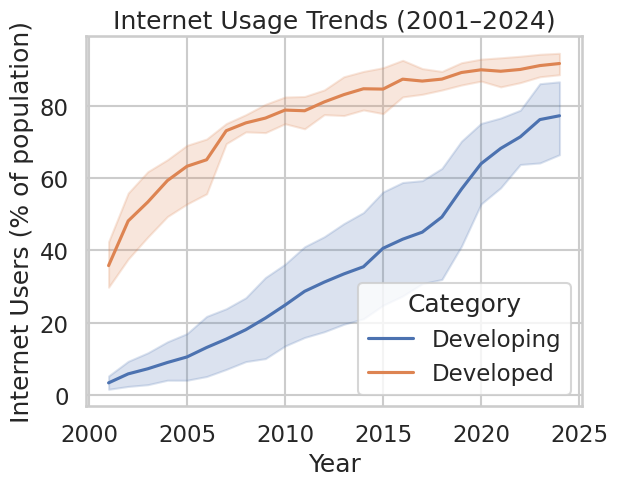

In [ ]:
# Step 9: Average Internet usage over time by group
sns.lineplot(data=df, x="Year", y="Internet_Usage", hue="Category", estimator="mean")
plt.title("Internet Usage Trends (2001–2024)")
plt.ylabel("Internet Users (% of population)")
plt.show()

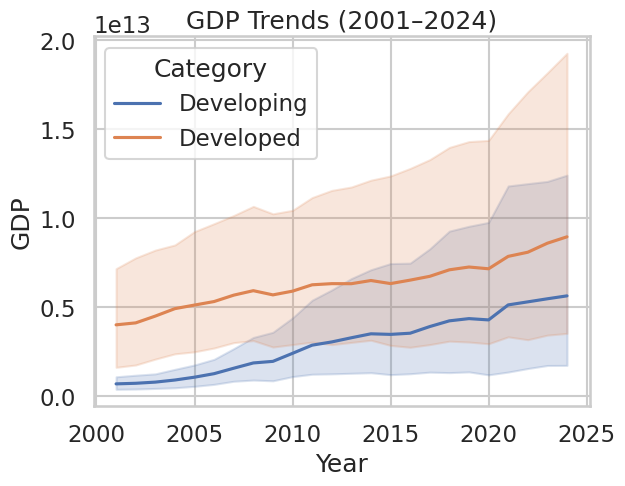

In [ ]:
# Step 10: GDP trends over time
sns.lineplot(data=df, x='Year', y='GDP', hue='Category', estimator='mean')
plt.title("GDP Trends (2001–2024)")
plt.ylabel("GDP")
plt.show()

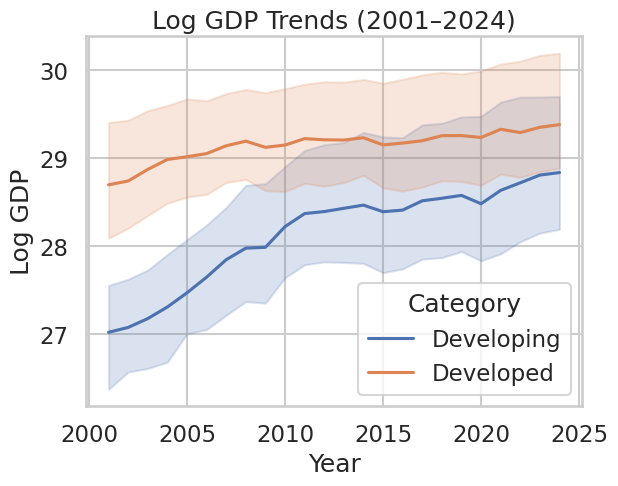

In [ ]:
# Step 10: GDP trends over time
sns.lineplot(data=df, x='Year', y='log_GDP', hue='Category', estimator='mean')
plt.title("Log GDP Trends (2001–2024)")
plt.ylabel("Log GDP")
plt.show()

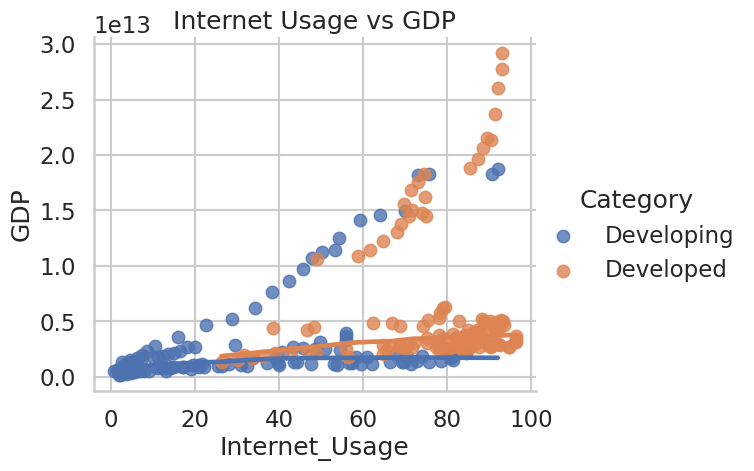

In [ ]:
# Step 11: Scatterplot to visualize relationship
sns.lmplot(
    data=df,
    x="Internet_Usage",
    y="GDP",
    hue="Category",
    lowess=True,
    height=5,
    aspect=1.2
)
plt.title("Internet Usage vs GDP")
plt.show()

In [ ]:
# Step 12: Compute correlation within groups
corr_table = df.groupby("Category")[["GDP", "Internet_Usage"]].corr().iloc[0::2, -1]
print(corr_table)

Category       
Developed   GDP    0.161229
Developing  GDP    0.449218
Name: Internet_Usage, dtype: float64


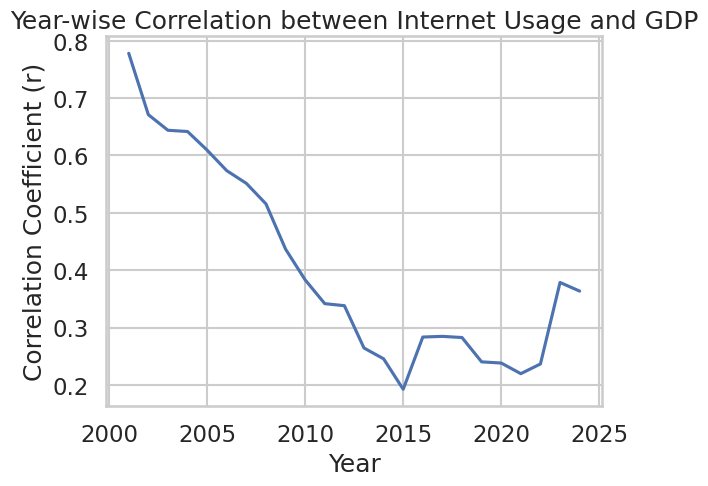

In [ ]:
# Step 13: Year-wise correlation trend
corr_by_year = (
    df.groupby("Year")[["Internet_Usage", "GDP"]]
      .corr()
      .iloc[0::2, -1]
      .reset_index()
)
sns.lineplot(data=corr_by_year, x="Year", y="GDP")
plt.title("Year-wise Correlation between Internet Usage and GDP")
plt.ylabel("Correlation Coefficient (r)")
plt.show()

In [ ]:
# Step 14: Create lagged Internet usage variable
df["Internet_Lag1"] = df.groupby("Country")["Internet_Usage"].shift(1)

In [ ]:
# Step 15: Check if lagged Internet usage correlates stronger with GDP
lag_corr = (
    df.groupby("Category")[["Internet_Lag1", "GDP"]]
      .corr()
      .iloc[0::2, -1]
)
print(lag_corr)

Category                 
Developed   Internet_Lag1    0.144479
Developing  Internet_Lag1    0.428962
Name: GDP, dtype: float64


In [ ]:
# Step 16: Base OLS Model (without country effects)
model1 = smf.ols("GDP ~ Internet_Usage", data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     46.02
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           9.19e-11
Time:                        05:22:47   Log-Likelihood:                -7361.6
No. Observations:                 240   AIC:                         1.473e+04
Df Residuals:                     238   BIC:                         1.473e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.769e+11   6.93e+11      0.

In [ ]:
# Step 17.1: Diagnostic Tests for Multicollinearity and Heteroskedasticity

# --- Multicollinearity (VIF) ---
# Exclude dummy variables (Country/Year) if you have too many; start simple
X = df[["Internet_Usage"]].copy()
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors:\n", vif_data)

# --- Heteroskedasticity (Breusch-Pagan & White tests) ---
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
white_test = het_white(model2.resid, model2.model.exog)

labels = ['LM Stat', 'LM p-value', 'F-Stat', 'F p-value']
print("\nBreusch–Pagan Test:", dict(zip(labels, bp_test)))
print("\nWhite Test:", dict(zip(labels, white_test)))



Variance Inflation Factors:
          Variable       VIF
0           const  4.443763
1  Internet_Usage  1.000000

Breusch–Pagan Test: {'LM Stat': np.float64(129.79485117619498), 'LM p-value': np.float64(2.021490746353078e-13), 'F-Stat': np.float64(7.352056906338577), 'F p-value': np.float64(1.265941275551311e-20)}

White Test: {'LM Stat': np.float64(240.0), 'LM p-value': np.float64(0.4696445374649022), 'F-Stat': np.float64(nan), 'F p-value': np.float64(nan)}


In [ ]:
# Step 17: Add fixed effects for country and year
model2 = smf.ols("GDP ~ Internet_Usage + C(Country) + C(Year)", data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     38.35
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           1.10e-70
Time:                        05:22:59   Log-Likelihood:                -7146.9
No. Observations:                 240   AIC:                         1.436e+04
Df Residuals:                     206   BIC:                         1.448e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
robust_model2 = model2.get_robustcov_results(cov_type='HC3')
print(robust_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     31.32
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           3.20e-63
Time:                        05:46:10   Log-Likelihood:                -7146.9
No. Observations:                 240   AIC:                         1.436e+04
Df Residuals:                     206   BIC:                         1.448e+04
Df Model:                          33                                         
Covariance Type:                  HC3                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
# Step 18: add interaction with development category
model3 = smf.ols("GDP ~ Internet_Usage * Category + C(Country) + C(Year)", data=df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     37.24
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           4.29e-70
Time:                        05:23:56   Log-Likelihood:                -7146.3
No. Observations:                 240   AIC:                         1.436e+04
Df Residuals:                     205   BIC:                         1.448e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
# Step 19: Check co-movement of growth rates
model_growth = smf.ols("GDP_growth ~ Internet_growth + C(Country) + C(Year)", data=df).fit()
print(model_growth.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     6.863
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           1.38e-18
Time:                        05:24:01   Log-Likelihood:                -769.06
No. Observations:                 230   AIC:                             1604.
Df Residuals:                     197   BIC:                             1718.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       